# Forecasting seat availability using random forests

[La Permanence](https://www.la-permanence.com) offers coworking space at two locations in Paris (*rue du Fer à Moulin* and *rue d'Alésia*).  

In this notebook we investigate the effectiveness of random forests in predicting the number of available seats for the next two weeks.  The results depicted below show that random forests are quite effective in picking up the general behavior in the availability of seats.  Random forests are the least effective when availability is particularly low and high.

The code in this notebook follows closely lessons 1 through 4 of fastai's [Introduction to Machine Learning for Coders](http://course18.fast.ai/ml) course.  The corresponding notebooks from the course's github repository are [lesson1-rf.ipynb and lesson2-rf-interpretation.ipynb](https://github.com/fastai/fastai/tree/master/courses/ml1).  This notebook uses [version 0.7](https://github.com/fastai/fastai/tree/master/old/fastai) of the fastai library.

## Imports, constants, and functions

In [1]:
# =======
# IMPORTS
# =======

import os
import sys
import re
# import tqdm  # class tqdm.tqdm imported from fastai.structured - see below

import pytz
import datetime

import math
import numpy as np
import pandas as pd
# from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

sys.path.append(os.path.join(os.path.expanduser("~"), "Computing/fastai/old"))
from fastai.structured import *

import matplotlib.pyplot as plt
# import seaborn as sns

%matplotlib inline

# =========
# CONSTANTS
# =========

    # Timezones
tz_utc = pytz.timezone("UTC")  # timestamp is in UTC standard
tz_paris = pytz.timezone("Europe/Paris")  # locations are in Paris, France

# Resampling rule: resolution of time regularization
RESOL = 2  # 10
RULE = f"{RESOL}T"
TWO_WEEKS = 2*7*24*(60 // RESOL)  # validation period is two weeks

# PLOTTING PARAMETERS
FIGSIZE = (16, 6)
ALPHA = 0.7

# Colors
COL_MOULIN = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
COL_ALESIA = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
COL_TRAIN = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
COL_VALID = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
COL_PREDICT = plt.rcParams['axes.prop_cycle'].by_key()['color'][4]

# =========
# FUNCTIONS
# =========

def split_vals(df, n):
    return df[:n].copy(), df[n:].copy()
        
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

## Load and preprocess data

The dataset consists of pure time-series:
-  `timestamp` gives the date and time (UTC) of data collection in the format "YYYY-MM-DD-hh-mm-ss" where
  - `YYYY=year`,
  - `MM=month`,
  - `DD=day`,
  - `hh=hour`,
  - `mm=minute`,
  - `ss=second`;  
-  `Moulin` gives the number of available seats at the rue du Fer à Moulin location (maximum is 63);
-  `Alésia` gives the number of available seats at the rue d'Alésia location (maximum is 82).  

If we are to use random forests, or decision trees, on the data, we need to convert the `timestamp` into a set of categorical features.  We will use:
- `Minuteofday`: this will capture the 24-hour seasonality in the data;  
- `Dayofweek`: this will capture the 7-day seasonality in the data.  

**Note**: the name of the dataset, `attendance.csv`, is a misnomer, as the file actually records the number of *available* seats, rather than the number of seats used.  

In [2]:
# %%prun
%time

# =========
# METADATA ON THE DATA
# =========

filename = 'attendance.csv'
foldername = 'Projects/la_permanence'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)
filesize = os.path.getsize(filepath)

COL_WIDTH = 20

if filesize > 1e6:
    print("{0}{1:d}MB".format("File size:".ljust(COL_WIDTH), filesize//int(1e6)))
elif filesize > 1e3:
    print("{0}{1:d}KB".format("File size:".ljust(COL_WIDTH), filesize//int(1e3)))
else:
    print("{0}{1:d}B".format("File size:".ljust(COL_WIDTH), filesize))

line_number = !wc -l < {filepath}
line_number = int(line_number[0])
print("{0}{1}".format("Number of rows:".ljust(COL_WIDTH), line_number))
first_row = !head -1 {filepath}
column_names = first_row[0].split(',')
print("{0}{1}".format("Names of columns:".ljust(COL_WIDTH), ", ".join(column_names)))


dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d-%H-%M-%S')

# =========
# LOAD DATA
# =========

print("Load data...")
raw_data = pd.read_csv(
    filepath,
    sep=',',
    dtype={'Moulin': np.uint8, 'Alésia': np.uint8},
    parse_dates=['timestamp'],
    date_parser=dateparse
)

# ========================
# ADJUSTING FOR TIMEZONES
# The `timestamp` values are in the UTC standard, while the coworking spaces are located in Paris, France:
# ========================

print("Adjust for timezones...")
raw_data['timestamp'] = raw_data['timestamp'].apply(lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_paris))

# ===================
# TIME REGULARIZATION
# The data is collected at irregular times and thus we resample (at a resolution specified in `RULE`) and interpolate to regularize the data:
# ===================

print("Perform time regularization...")
raw_data.set_index("timestamp", inplace=True)
raw_data = raw_data.resample(RULE).mean().interpolate().round().astype(np.uint8)
raw_data.reset_index('timestamp', inplace=True)

# ==========================
# EXPAND DATE INFORMATION
# Create new features from `timestamp` to pass to decision tree
# ==========================

print("Expand date information...")
timestamps = raw_data.loc[:, ['timestamp']]
# attributes = ['Week', 'Dayofweek', 'Hour', 'Minute']
attributes = ['Dayofweek', 'Hour', 'Minute']
for attr in attributes:
    raw_data[attr] = getattr(raw_data['timestamp'].dt, attr.lower())
raw_data['Minuteofday'] = 60*raw_data['Hour'] + raw_data['Minute']
raw_data.drop(['timestamp', 'Hour', 'Minute'], axis=1, inplace=True)

print("New columns: {0}".format(", ".join(raw_data.columns)))
# ===============
# TYPE CONVERSION
# ===============

print("Type conversion...")
# raw_data['Week'] = raw_data['Week'].astype(np.uint8)
raw_data['Dayofweek'] = raw_data['Dayofweek'].astype(np.uint8)
raw_data['Minuteofday'] = raw_data['Minuteofday'].astype(np.uint16)

# ===============================================
# Separating dependent from independent variables
# Also: extract data from location in rue du Fer à Moulin
# ===============================================
print("Separate dependent from independent variables...")
df_trn, y_trn, nas = proc_df(raw_data.drop('Alésia', axis=1), 'Moulin')

# =======================================
# Split into training and validation sets
# =======================================

print("Split into training and validation sets...")
n_valid = TWO_WEEKS  
n_trn = raw_data.shape[0] - n_valid

X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(raw_data, n_trn)

# For plotting purposes:
timestamps_train = timestamps.iloc[0:n_trn].copy()
timestamps_valid = timestamps.iloc[n_trn:].copy()

print("Done.")

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.72 µs
File size:          1MB
Number of rows:     45966
Names of columns:   timestamp, Moulin, Alésia
Load data...
Adjust for timezones...
Perform time regularization...
Expand date information...
New columns: Moulin, Alésia, Dayofweek, Minuteofday
Type conversion...
Separate dependent from independent variables...
Split into training and validation sets...
Done.


## Forecasting using random forests

### Performance metrics and parameter values

There are many parameters in [`sklearn.RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) that can be adjusted in order to improve the predictions and we will focus on the following.  
-  The number of trees: `n_estimators`; the default value is (currently) **10** (soon to be changed to 100)
.   
-  The minimum number of samples required to be at a leaf node: `min_leaves_sample`; the default value is **1**.  
-  The maximum number of features to consider when looking for the best split: `max_features`; the default is to use **all** features.  

The choice of values for these parameters is dictated by the metrics used to assess the performance of random forests.  Here we measure:  
- the root mean squared error (RMSE) and  
- the $R^2$ score.  

Near optimal choices have been determined empirically in the notebook `la-permanence-random-forests-parameters.ipynb`.

### Training and validation sets

/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


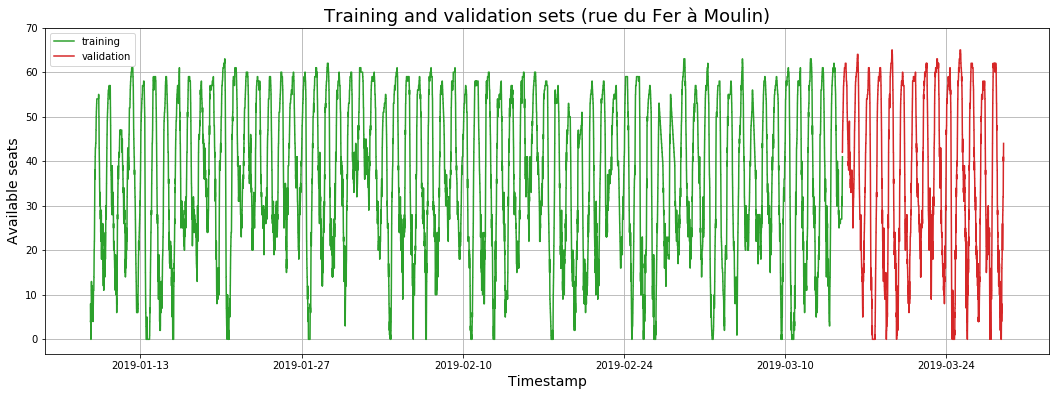

In [3]:
fig, ax = plt.subplots(figsize=(18, 6));

plt.plot(timestamps_train['timestamp'], y_train, COL_TRAIN);
plt.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);

ax.set_title("Training and validation sets (rue du Fer à Moulin)", fontsize=18)

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));

ax.set_xlabel("Timestamp", fontsize=14);

ax.legend(['training', 'validation'], loc='upper left')
ax.grid();
# plt.savefig("moulin-training-validation-split.png")

## Parameter values
We have a choice of prescribing either `max_depth` or `min_samples_leaf`.

### Prescribing `max_depth`

In [4]:
n_estimators = 100 # 5 # 100
max_depth = 10  # 5

In [5]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_depth=max_depth)
%time m.fit(X_train, y_train)
COL_WIDTH = 20
print("{0}: {1}".format("RMSE (train)".ljust(COL_WIDTH), rmse(m.predict(X_train), y_train)))
print("{0}: {1}".format("RMSE (validation)".ljust(COL_WIDTH), rmse(m.predict(X_valid), y_valid)))
print("{0}: {1}".format("R2 (train)".ljust(COL_WIDTH), m.score(X_train, y_train)))
print("{0}: {1}".format("R2 (validation)".ljust(COL_WIDTH), m.score(X_valid, y_valid)))

y_predict = m.predict(X_valid)

CPU times: user 2.3 s, sys: 37.2 ms, total: 2.34 s
Wall time: 347 ms
RMSE (train)        : 5.790425789738914
RMSE (validation)   : 6.3923443190419995
R2 (train)          : 0.8897896482493334
R2 (validation)     : 0.8964938939140742


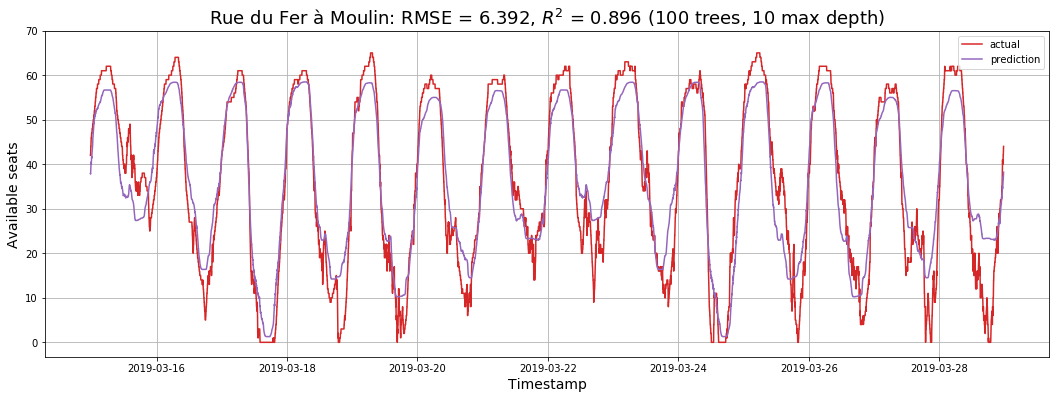

In [6]:
fig, ax = plt.subplots(figsize=(18, 6));
ax.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);
ax.plot(timestamps_valid['timestamp'], y_predict, COL_PREDICT);
ax.set_title(
    "Rue du Fer à Moulin: RMSE = {0:.4g}, $R^2$ = {1:.3g} ({2} trees, {3} max depth)".format(
        rmse(m.predict(X_valid), y_valid),
        m.score(X_valid, y_valid),
        n_estimators,
        max_depth
    ),
    fontsize=18
);

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['actual', 'prediction'], loc='upper right')
ax.grid();
# plt.savefig("moulin-random-forest-forecast-max-depth-{0}.png".format(max_depth));

## Presribing `min_samples_leaf`

In [7]:
n_estimators = 100
min_samples_leaf = 200

In [8]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)
%time m.fit(X_train, y_train)
COL_WIDTH = 20
print("{0}: {1}".format("RMSE (train)".ljust(COL_WIDTH), rmse(m.predict(X_train), y_train)))
print("{0}: {1}".format("RMSE (validation)".ljust(COL_WIDTH), rmse(m.predict(X_valid), y_valid)))
print("{0}: {1}".format("R2 (train)".ljust(COL_WIDTH), m.score(X_train, y_train)))
print("{0}: {1}".format("R2 (validation)".ljust(COL_WIDTH), m.score(X_valid, y_valid)))

y_predict = m.predict(X_valid)

CPU times: user 2.07 s, sys: 28.6 ms, total: 2.1 s
Wall time: 242 ms
RMSE (train)        : 5.899434886522478
RMSE (validation)   : 6.451365212417469
R2 (train)          : 0.8856010041120074
R2 (validation)     : 0.8945737140772425


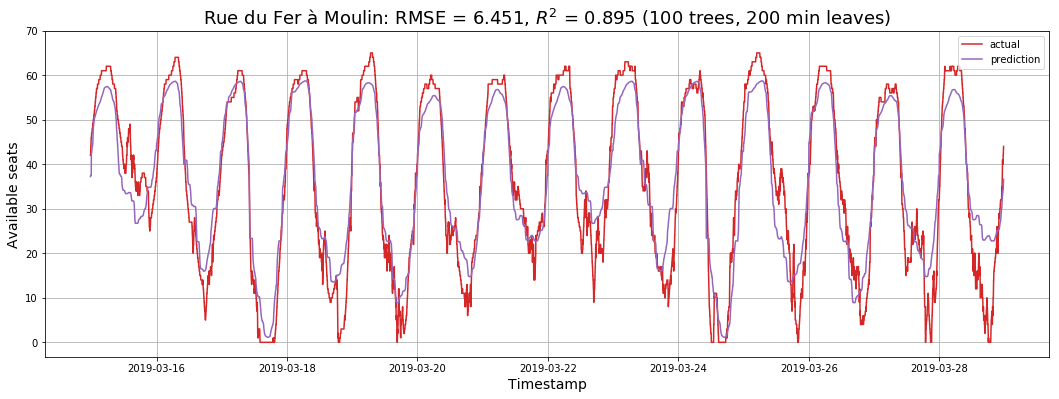

In [9]:
fig, ax = plt.subplots(figsize=(18, 6));
ax.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);
ax.plot(timestamps_valid['timestamp'], y_predict, COL_PREDICT);
ax.set_title(
    "Rue du Fer à Moulin: RMSE = {0:.4g}, $R^2$ = {1:.3g} ({2} trees, {3} min leaves)".format(
        rmse(m.predict(X_valid), y_valid),
        m.score(X_valid, y_valid),
        n_estimators,
        min_samples_leaf
    ),
    fontsize=18
);

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['actual', 'prediction'], loc='upper right')
ax.grid();
# plt.savefig("moulin-random-forest-forecast-min-samples-leaf-{0}.png".format(min_samples_leaf));

## Rue d'Alésia

We now consider the data from rue d'Alésia.

In [10]:
df, y, nas = proc_df(raw_data.drop('Moulin', axis=1), 'Alésia')

X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

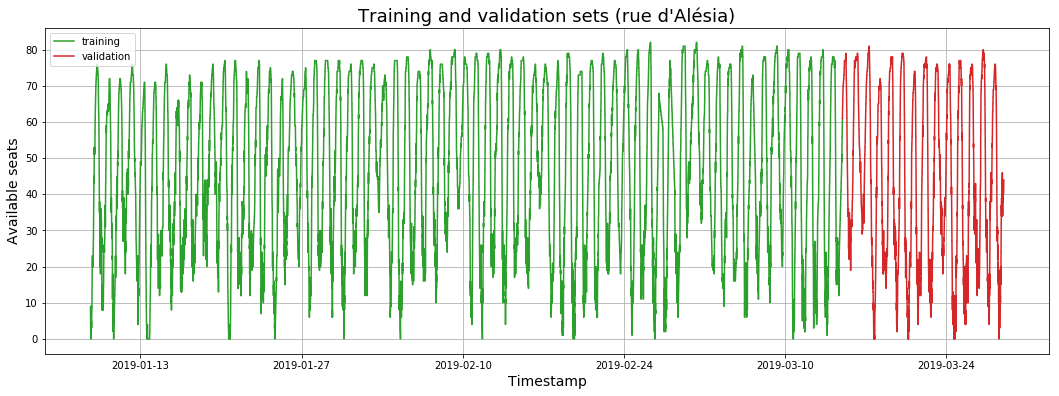

In [11]:
fig, ax = plt.subplots(figsize=(18, 6));

plt.plot(timestamps_train['timestamp'], y_train, COL_TRAIN);
plt.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);

ax.set_title("Training and validation sets (rue d'Alésia)", fontsize=18)

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 90, 10));

ax.set_xlabel("Timestamp", fontsize=14);

ax.legend(['training', 'validation'], loc='upper left');
ax.grid();
# plt.savefig("alesia-training-validation-split.png")

### Prescribing `max_depth`

In [12]:
n_estimators = 100 # 5 # 100
max_depth = 9 # 10  # 5

In [13]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_depth=max_depth)
%time m.fit(X_train, y_train)
COL_WIDTH = 20
print("{0}: {1}".format("RMSE (train)".ljust(COL_WIDTH), rmse(m.predict(X_train), y_train)))
print("{0}: {1}".format("RMSE (validation)".ljust(COL_WIDTH), rmse(m.predict(X_valid), y_valid)))
print("{0}: {1}".format("R2 (train)".ljust(COL_WIDTH), m.score(X_train, y_train)))
print("{0}: {1}".format("R2 (validation)".ljust(COL_WIDTH), m.score(X_valid, y_valid)))

y_predict = m.predict(X_valid)

CPU times: user 2.09 s, sys: 34 ms, total: 2.13 s
Wall time: 346 ms
RMSE (train)        : 6.92821745078176
RMSE (validation)   : 7.845049828999951
R2 (train)          : 0.91074349291703
R2 (validation)     : 0.8978167406177483


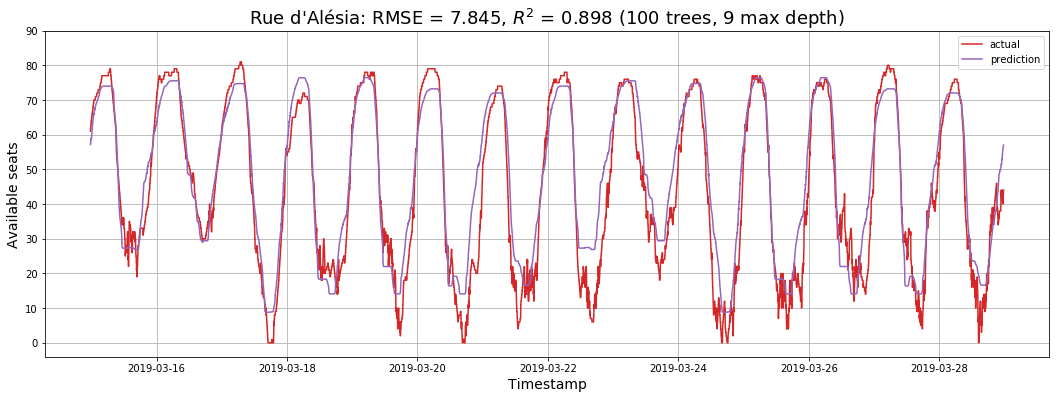

In [14]:
fig, ax = plt.subplots(figsize=(18, 6));
ax.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);
ax.plot(timestamps_valid['timestamp'], y_predict, COL_PREDICT);
ax.set_title(
    "Rue d'Alésia: RMSE = {0:.4g}, $R^2$ = {1:.3g} ({2} trees, {3} max depth)".format(
        rmse(m.predict(X_valid), y_valid),
        m.score(X_valid, y_valid),
        n_estimators,
        max_depth
    ),
    fontsize=18
);

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 100, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['actual', 'prediction'], loc='upper right')
ax.grid();
# plt.savefig("alesia-random-forest-forecast-max-depth-{0}.png".format(max_depth));

## Presribing `min_samples_leaf`

In [15]:
n_estimators = 100
min_samples_leaf = 10

In [16]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)
%time m.fit(X_train, y_train)
COL_WIDTH = 20
print("{0}: {1}".format("RMSE (train)".ljust(COL_WIDTH), rmse(m.predict(X_train), y_train)))
print("{0}: {1}".format("RMSE (validation)".ljust(COL_WIDTH), rmse(m.predict(X_valid), y_valid)))
print("{0}: {1}".format("R2 (train)".ljust(COL_WIDTH), m.score(X_train, y_train)))
print("{0}: {1}".format("R2 (validation)".ljust(COL_WIDTH), m.score(X_valid, y_valid)))

y_predict = m.predict(X_valid)

CPU times: user 2.77 s, sys: 59.5 ms, total: 2.83 s
Wall time: 335 ms
RMSE (train)        : 6.896034893605309
RMSE (validation)   : 7.865126899994498
R2 (train)          : 0.9115707853832108
R2 (validation)     : 0.8972930560646393


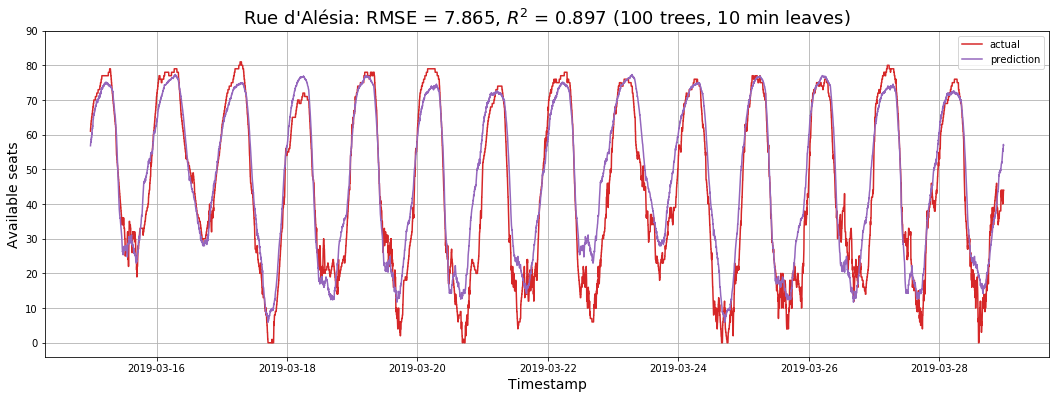

In [17]:
fig, ax = plt.subplots(figsize=(18, 6));
ax.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);
ax.plot(timestamps_valid['timestamp'], y_predict, COL_PREDICT);
ax.set_title(
    "Rue d'Alésia: RMSE = {0:.4g}, $R^2$ = {1:.3g} ({2} trees, {3} min leaves)".format(
        rmse(m.predict(X_valid), y_valid),
        m.score(X_valid, y_valid),
        n_estimators,
        min_samples_leaf
    ),
    fontsize=18
);

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 100, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['actual', 'prediction'], loc='upper right')
ax.grid();
# plt.savefig("alesia-random-forest-forecast-min-samples-leaf-{0}.png".format(min_samples_leaf));